In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
import sys
import cvxpy as cp

In [2]:
from reconstruction_alg import DD

In [15]:
x_t = create_input(100,0.9)
m_t = create_tests(80,100,0.9)

dd = DD(x_t,m_t)
dd.reconstruct()
dd.score()

0.99

In [4]:
def create_input(n,p):
    
    return np.random.choice([0,1],size=n,p=[p,1-p])

In [3]:
xtest = create_input(100,0.7)
xtest.nonzero()

(array([ 4, 11, 12, 17, 20, 24, 26, 29, 35, 36, 38, 39, 40, 41, 47, 53, 55,
        63, 65, 75, 80, 81, 90, 91, 99]),)

In [5]:
def create_tests(T,n,alpha):
    
    return np.random.choice([0,1],size=(T,n),p=[alpha,1-alpha])

In [5]:
create_tests(60,100,0.9)@create_input(100,0.9)

array([0, 0, 1, 0, 1, 2, 1, 1, 4, 3, 3, 4, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       3, 1, 1, 2, 1, 3, 2, 1, 0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 1, 1, 1, 3,
       2, 1, 1, 1, 0, 1, 0, 1, 1, 4, 1, 1, 1, 0, 1, 1])

# COMP algorithm

In [378]:
class COMP:
    
    """ 
    
    The COMP algorithm conservatively reconstructs the true vector x given a test matrix and a test result.
    It works by declaring healthy only the individuals that are in a group with negative test result.
    Initialize COMP with the true (unknown) vector x and the test matrix. 
    
    * reconstruct() outputs the vector reconstructed by the COMP algorithm.
    
    * score() computes the 0-1 accuracy of the algorithm.
    
    * average_score(mat_size,number,alpha) is a function meant for evaluating the performance of the COMP algorithm 
    with random tests. It computes the 0-1 accuracy for number test designs with mat_size random tests 
    (parametrized by alpha), and outputes the average performance of the COMP algorithm. 
    
    """
    
    def __init__(self,true_x,test_matrix):
        
        self.true_x = true_x
        self.popsize = true_x.shape[0]
        self.test_matrix = test_matrix
        
        if self.true_x.shape[0] != (self.test_matrix.shape)[1]:
            
            raise Exception("Number of columns in the test matrix and true vector size should be equal.")
            
        self.test_result = test_matrix@true_x
        
        
    def reconstruct(self,test_mat=None):
        
        
        if type(test_mat) != type(None):
                        
            #Allows for reconstruction with different test matrix, used in average_score()
            
            test_matrix = test_mat
            test_result = test_mat@(self.true_x)
            
        else:
            
            test_matrix = self.test_matrix
            test_result = self.test_result
        
        reconstructed_x = np.ones(test_matrix.shape[1])
        
        for line in np.arange(test_matrix.shape[0]):
            
            if test_result[line] == 0:
                
                def_negatives = test_matrix[line].nonzero()
                
                reconstructed_x[def_negatives] = 0
                
        return reconstructed_x
    
    
    def score(self,test_mat=None):
                
        if type(test_mat) != type(None):
            
            #Allows for reconstruction with different test matrix, used in average_score()
            
            reconstructed_x = self.reconstruct(test_mat=test_mat)
        
        else:
            
            reconstructed_x = self.reconstruct()
            
            
        diff = reconstructed_x - self.true_x
        diff[diff != 0] = 1
        
        return np.mean(1-diff)
    
    
    def average_score(self,mat_size,number,alpha):
        
        output = 0
        
        for i in np.arange(number):
            
            random_matrix = np.random.choice([0,1],size=(mat_size,self.popsize),p=[alpha,1-alpha])
            
            output += self.score(test_mat=random_matrix)
            
        return output/number
    
    def confusion_matrix(self,absv = False, plot=False):

        if plot == False and absv == True :

            return confusion_matrix(self.reconstruct(),self.true_x)

        if plot == False and absv == False : 

            return confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x))

        if plot == True and absv == False:

            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x)),annot=True)
            plt.show()

        if plot == True and absv == True:

            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x),annot=True)
            plt.show()

In [27]:
x_test = create_input(150,0.9)
mat_test = create_tests(100,150,0.9) 
COMP_alg = COMP(x_test,mat_test) 
rec_x = COMP_alg.reconstruct()
print(COMP_alg.score())
print(COMP_alg.average_score(80,10000,0.9))

0.92
0.8295673333333184


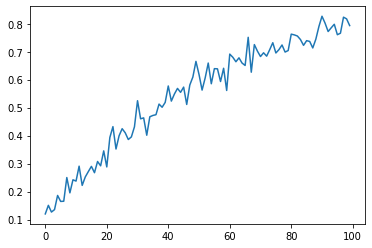

In [28]:
x_test = create_input(150,0.9)

results = []

comp = COMP(x_test,mat_test)

for test_number in np.arange(100):
    
    output = comp.average_score(test_number,10,0.9)
    results.append(output)
    
plt.plot(results)
plt.show()

    
    

0.79


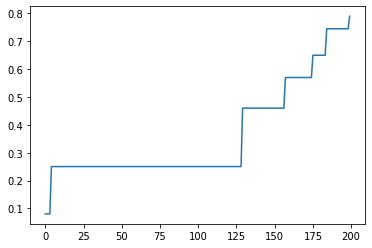

In [29]:
x_test = create_input(200,0.9)
mat_test = create_tests(200,200,0.8) 
COMP_alg = COMP(x_test,mat_test) 
rec_x = COMP_alg.reconstruct()
print(COMP_alg.score())

results = []

for i in np.arange(0,200):
    
    output = COMP_alg.score(mat_test[0:i,:])
    results.append(output)
    
plt.plot(results)
plt.show()

# DD Algorithm

In [30]:
class DD:
    
    def __init__(self,true_x,test_matrix):
        
        self.true_x = true_x
        self.popsize = true_x.shape[0]
        self.test_matrix = test_matrix
        
        if self.true_x.shape[0] != (self.test_matrix.shape)[1]:
            
            raise Exception("Number of columns in the test matrix and true vector size should be equal.")
            
        self.test_result = test_matrix@true_x
        
    def reconstruct(self,test_mat=None):
                
        if type(test_mat) != type(None):
                        
            #Allows for reconstruction with different test matrix, used in average_score()
            
            test_matrix = test_mat
            test_result = test_mat@(self.true_x)
            
        else:
            
            test_matrix = self.test_matrix
            test_result = self.test_result
        
        nd = np.ones(test_matrix.shape[1])
        
        for line in np.arange(test_matrix.shape[0]):
            
            if test_result[line] == 0:
                
                def_negatives = test_matrix[line].nonzero()
                
                nd[def_negatives] = 0
                
        nd_c_indices = np.nonzero(nd)[0]
        nd_c = 1-nd
        nd_indices = np.nonzero(nd == 0)
        
        defectives = []
        
        for line in np.arange(test_matrix.shape[0]):
                        
            test_indices = test_matrix[line].nonzero()[0]
            
            overlap = len(np.intersect1d(test_indices,nd_c_indices))
            
            if overlap == 1:
                
                defective = np.intersect1d(test_indices,nd_c_indices)
                defectives.append(defective[0])
                
        reconstructed_x = np.zeros(test_matrix.shape[1])
        reconstructed_x[defectives]=1
        
        return reconstructed_x
    
    def score(self,test_mat=None):
                
        if type(test_mat) != type(None):
            
            #Allows for reconstruction with different test matrix, used in average_score()
            
            reconstructed_x = self.reconstruct(test_mat=test_mat)
        
        else:
            
            reconstructed_x = self.reconstruct()
            
            
        diff = reconstructed_x - self.true_x
        diff[diff != 0] = 1
        
        return np.mean(1-diff)
    
    def average_score(self,mat_size,number,alpha):
        
        output = 0
        
        for i in np.arange(number):
            
            random_matrix = np.random.choice([0,1],size=(mat_size,self.popsize),p=[alpha,1-alpha])
            
            output += self.score(test_mat=random_matrix)
            
        return output/number 
    
    def confusion_matrix(self,absv = False, plot=False):

        if plot == False and absv == True :

            return confusion_matrix(self.reconstruct(),self.true_x)

        if plot == False and absv == False : 

            return confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x))

        if plot == True and absv == False:

            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x)),annot=True)
            plt.show()

        if plot == True and absv == True:

            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x),annot=True)
            plt.show()

In [31]:
x_test = create_input(150,0.9)
mat_test = create_tests(100,150,0.9) 
comp = COMP(x_test,mat_test) 
dd = DD(x_test,mat_test)
rec_x_comp = comp.reconstruct()
rec_x_dd = dd.reconstruct()

print(comp.score())
print(dd.score())
print('DD average score:',dd.average_score(100,1000,0.9))
print('Comp average score:',comp.average_score(100,1000,0.9))

0.82
0.9
DD average score: 0.9216733333333283
Comp average score: 0.8653666666666646


# SCOMP algorithm

In [371]:
class SCOMP:
    
    def __init__(self,true_x,test_matrix):
        
        self.true_x = true_x
        self.popsize = true_x.shape[0]
        self.test_matrix = test_matrix
        
        if self.true_x.shape[0] != (self.test_matrix.shape)[1]:
            
            raise Exception("Number of columns in the test matrix and true vector size should be equal.")
            
        self.test_result = test_matrix@true_x
        
    def reconstruct(self,test_mat=None):
                
        if type(test_mat) != type(None):
                        
            #Allows for reconstruction with different test matrix, used in average_score()
            
            test_matrix = test_mat
            test_result = test_mat@(self.true_x)
            
        else:
            
            test_matrix = self.test_matrix
            test_result = self.test_result
        
        nd = np.ones(test_matrix.shape[1])
        
        #COMP
        
        for line in np.arange(test_matrix.shape[0]):
            
            if test_result[line] == 0:
                
                def_negatives = test_matrix[line].nonzero()
                
                nd[def_negatives] = 0
                
        #DD
        
        #nd : definetly negs 
        #pd : possibly defectives 
        
        pd_indices = np.nonzero(nd)[0]
        pd = 1-nd
        nd_indices = np.nonzero(nd == 0)
        
        defectives = []
        
        for line in np.arange(test_matrix.shape[0]):
                        
            test_indices = test_matrix[line].nonzero()[0]
            
            overlap = len(np.intersect1d(test_indices,pd_indices))
            
            if overlap == 1:
                
                defective = np.intersect1d(test_indices,pd_indices)
                defectives.append(defective[0])
                
        estimated_x = np.zeros(test_matrix.shape[1])
        estimated_x[defectives] = 1
                
        while np.all(test_matrix@estimated_x == test_matrix@self.true_x) == False :
            
            positive_tests = test_result.nonzero()[0]
            
            unexplained_tests =[]
            
            for test in positive_tests:
                                
                if len(np.intersect1d(test_matrix[test].nonzero()[0],estimated_x.nonzero()[0])) == 0:
                
                    unexplained_tests.append(test)
                       
            counter = np.zeros(test_matrix.shape[1])
                       
            for i in pd_indices:
                       
               counter[i] = len(np.intersect1d(test_matrix[:,i].nonzero(),unexplained_tests))
                       
            selected_i = np.random.choice(np.flatnonzero(counter == counter.max()))
            
            if np.all(counter == 0):
                
                return estimated_x
            
            else:
            
                estimated_x[selected_i] = 1
        
        return estimated_x
    
    def score(self,test_mat=None):
                
        if type(test_mat) != type(None):
                        
            reconstructed_x = self.reconstruct(test_mat=test_mat)
        
        else:
            
            reconstructed_x = self.reconstruct()
            
        diff = reconstructed_x - self.true_x
        diff[diff != 0] = 1
        
        return np.mean(1-diff)
    
    def average_score(self,mat_size,number,alpha):
        
        output = 0
        
        for i in np.arange(number):
            
            random_matrix = np.random.choice([0,1],size=(mat_size,self.popsize),p=[alpha,1-alpha])
            
            output += self.score(test_mat=random_matrix)
                
        return output/number
    
    def confusion_matrix(self,absv = False, plot=False):
            
        if plot == False and absv == True :
            
            return confusion_matrix(self.reconstruct(),self.true_x)
        
        if plot == False and absv == False : 
            
            return confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x))
        
        if plot == True and absv == False:
            
            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x)),annot=True)
            plt.show()
            
        if plot == True and absv == True:
            
            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x),annot=True)
            plt.show()
            


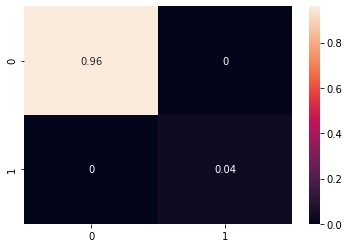

In [377]:
x_test = create_input(150,0.9)
mat_test = create_tests(100,150,0.9) 
scomp = SCOMP(x_test,mat_test)
comp = COMP(x_test,mat_test) 
dd = DD(x_test,mat_test)

scomp.confusion_matrix(absv=False,plot=True)

# LP Relaxation Algorithm

In [548]:
class LP:
    
    def __init__(self,true_x,test_matrix):
        
        self.true_x = true_x
        self.popsize = true_x.shape[0]
        self.test_matrix = test_matrix
        
        if self.true_x.shape[0] != (self.test_matrix.shape)[1]:
            
            raise Exception("Number of columns in the test matrix and true vector size should be equal.")
            
        self.test_result = test_matrix@true_x
        
        
    def reconstruct(self,test_mat=None):
        
        
        if type(test_mat) != type(None):
                        
            #Allows for reconstruction with different test matrix, used in average_score()
            
            test_matrix = test_mat
            test_result = test_mat@(self.true_x)
            
        else:
            
            test_matrix = self.test_matrix
            test_result = self.test_result
        
        positive_tests = test_matrix[test_result != 0,:]
        negative_tests = test_matrix[test_result == 0,:]

        x = cp.Variable(self.popsize)
        objective = cp.Minimize(cp.sum(x))
        constraints = [ 0 <= x, x <= 1, negative_tests@x == 0,test_result[test_result != 0] <= positive_tests@x]
        prob = cp.Problem(objective,constraints)
        prob.solve()
        
        optimal_x = x.value
                 
        optimal_x[optimal_x < 1] = 0
        
        return optimal_x.astype(int)
    
    def score(self,test_mat=None):
                
        if type(test_mat) != type(None):
            
            #Allows for reconstruction with different test matrix, used in average_score()
            
            reconstructed_x = self.reconstruct(test_mat=test_mat)
        
        else:
            
            reconstructed_x = self.reconstruct()
            
            
        diff = reconstructed_x - self.true_x
        diff[diff != 0] = 1
        
        return np.mean(1-diff)
    
    
    def average_score(self,mat_size,number,alpha):
        
        output = 0
        
        for i in np.arange(number):
            
            random_matrix = np.random.choice([0,1],size=(mat_size,self.popsize),p=[alpha,1-alpha])
            
            output += self.score(test_mat=random_matrix)
            
        return output/number
    
    def confusion_matrix(self,absv = False, plot=False):

        if plot == False and absv == True :

            return confusion_matrix(self.reconstruct(),self.true_x)

        if plot == False and absv == False : 

            return confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x))

        if plot == True and absv == False:

            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x)/np.sum(confusion_matrix(self.reconstruct(),self.true_x)),annot=True)
            plt.show()

        if plot == True and absv == True:

            sns.heatmap(confusion_matrix(self.reconstruct(),self.true_x),annot=True)
            plt.show()

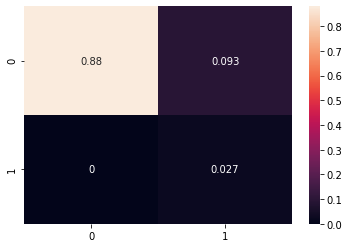

In [556]:
x_test = create_input(150,0.9)
mat_test = create_tests(100,150,0.9) 
lp = LP(x_test,mat_test)
lp.reconstruct()
lp.score()
lp.confusion_matrix(plot=True)